<a href="https://colab.research.google.com/github/bitunsen/datascience/blob/master/DogBreedClassificationUsingTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
with ZipFile('/content/drive/My Drive/DataSet/dog-breed-identification.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [4]:
!ls -lrt

total 26388
drwxr-xr-x 1 root root     4096 Nov 13 17:33 sample_data
drwx------ 5 root root     4096 Nov 17 22:34 drive
-rw-r--r-- 1 root root   482063 Nov 17 22:34 labels.csv
-rw-r--r-- 1 root root 25200295 Nov 17 22:34 sample_submission.csv
drwxr-xr-x 2 root root   663552 Nov 17 22:35 test
drwxr-xr-x 2 root root   663552 Nov 17 22:35 train


In [5]:
!mkdir dataset
!mv train dataset/
!mv test dataset/
!mv *.csv dataset/

In [6]:
!ls -lrt dataset/

total 26380
-rw-r--r-- 1 root root   482063 Nov 17 22:34 labels.csv
-rw-r--r-- 1 root root 25200295 Nov 17 22:34 sample_submission.csv
drwxr-xr-x 2 root root   663552 Nov 17 22:35 test
drwxr-xr-x 2 root root   663552 Nov 17 22:35 train


In [7]:
!ls -lrt dataset/train/|head -5

total 373708
-rw-r--r-- 1 root root   33339 Nov 17 22:35 001cdf01b096e06d78e9e5112d419397.jpg
-rw-r--r-- 1 root root   49514 Nov 17 22:35 001513dfcb2ffafc82cccf4d8bbaba97.jpg
-rw-r--r-- 1 root root   54775 Nov 17 22:35 000bec180eb18c7604dcecc8fe0dba07.jpg
-rw-r--r-- 1 root root   26442 Nov 17 22:35 0021f9ceb3235effd7fcde7f7538ed62.jpg


In [8]:
dog_breed_df = pd.read_csv('dataset/labels.csv')
dog_breed_df.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


# Let us see how the images are distributed in the training set.

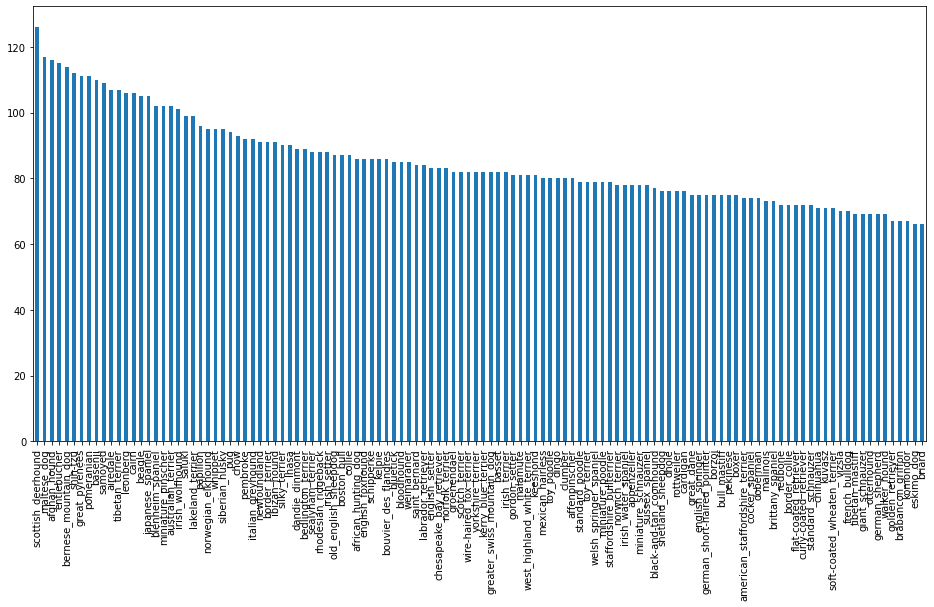

In [9]:
figure = plt.figure(figsize=(16, 8))
dog_breed_df['breed'].value_counts().plot(kind='bar')

In [10]:
value_counts = dog_breed_df['breed'].value_counts()
value_counts_dict = {}
for breed, count in value_counts.iteritems():
  #print("Breed :: " + breed + " :: COUNT :: " + str(count))
  value_counts_dict[breed] = count

print(value_counts_dict)

{'scottish_deerhound': 126, 'maltese_dog': 117, 'afghan_hound': 116, 'entlebucher': 115, 'bernese_mountain_dog': 114, 'shih-tzu': 112, 'great_pyrenees': 111, 'pomeranian': 111, 'basenji': 110, 'samoyed': 109, 'airedale': 107, 'tibetan_terrier': 107, 'leonberg': 106, 'cairn': 106, 'beagle': 105, 'japanese_spaniel': 105, 'blenheim_spaniel': 102, 'miniature_pinscher': 102, 'australian_terrier': 102, 'irish_wolfhound': 101, 'saluki': 99, 'lakeland_terrier': 99, 'papillon': 96, 'norwegian_elkhound': 95, 'whippet': 95, 'siberian_husky': 95, 'pug': 94, 'chow': 93, 'pembroke': 92, 'italian_greyhound': 92, 'newfoundland': 91, 'border_terrier': 91, 'ibizan_hound': 91, 'silky_terrier': 90, 'lhasa': 90, 'dandie_dinmont': 89, 'bedlington_terrier': 89, 'sealyham_terrier': 88, 'rhodesian_ridgeback': 88, 'irish_setter': 88, 'old_english_sheepdog': 87, 'boston_bull': 87, 'collie': 87, 'african_hunting_dog': 86, 'english_foxhound': 86, 'schipperke': 86, 'kelpie': 86, 'bouvier_des_flandres': 86, 'bluetic

dataset/train/000bec180eb18c7604dcecc8fe0dba07.jpg ::: boston_bull
dataset/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg ::: dingo
dataset/train/001cdf01b096e06d78e9e5112d419397.jpg ::: pekinese
dataset/train/00214f311d5d2247d5dfe4fe24b2303d.jpg ::: bluetick
dataset/train/0021f9ceb3235effd7fcde7f7538ed62.jpg ::: golden_retriever
dataset/train/002211c81b498ef88e1b40b9abf84e1d.jpg ::: bedlington_terrier
dataset/train/00290d3e1fdd27226ba27a8ce248ce85.jpg ::: bedlington_terrier
dataset/train/002a283a315af96eaea0e28e7163b21b.jpg ::: borzoi
dataset/train/003df8b8a8b05244b1d920bb6cf451f9.jpg ::: basenji
dataset/train/0042188c895a2f14ef64a918ed9c7b64.jpg ::: scottish_deerhound
dataset/train/004396df1acd0f1247b740ca2b14616e.jpg ::: shetland_sheepdog
dataset/train/0067dc3eab0b3c3ef0439477624d85d6.jpg ::: walker_hound
dataset/train/00693b8bc2470375cc744a6391d397ec.jpg ::: maltese_dog
dataset/train/006cc3ddb9dc1bd827479569fcdc52dc.jpg ::: bluetick
dataset/train/0075dc49dab4024d12fafe67074d8a81.jpg ::

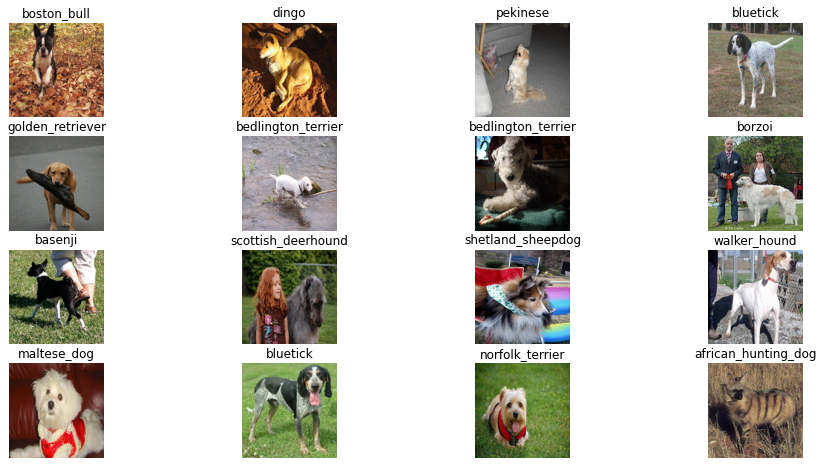

In [11]:
def show_some_images(_df, folder):
    figure = plt.figure(figsize=(16, 8))
    num_of_images = 16
    for i in range(num_of_images):
      img_path = folder + "/" + _df['id'].iloc[i] + ".jpg"
      print(img_path + " ::: " + _df['breed'].iloc[i])
      img_data = Image.open(img_path)
      new_width  = 128
      new_height = 128
      img_data = img_data.resize((new_width, new_height), Image.ANTIALIAS)
      plt.subplot(4, 4, i+1)
      plt.axis('off')
      plt.imshow(img_data, cmap='gray_r')
      plt.title(_df['breed'].iloc[i])

show_some_images(dog_breed_df, 'dataset/train')

In [12]:
def get_key_from_dict(_dict, _value):
  for key, val in _dict.items():
    if _value == val:
      return key
  return "NO_KEY_FOUND"

In [13]:
TRAIN_IMAGE_PATH = 'dataset/train'

# Prepare data for processing

In [14]:
from tensorflow.keras import utils as np_utils

In [15]:
dog_breeds = dog_breed_df['breed'].unique()
num_of_labels = len(dog_breeds)
print("Number of Breeds ::", num_of_labels)
dog_breeds_dict = {name: i for i, name in enumerate(dog_breeds)}

count = 0
image_path_list = []
breed_label_code_list = []
encoded_breed_list = []
for image_id, breed_name in zip(dog_breed_df['id'], dog_breed_df['breed']):
  image_path = os.path.join(TRAIN_IMAGE_PATH, image_id + ".jpg")
  #print("Image ID :: ", image_id, " ::: Path :: ", image_path, " ::: Breed Code :: ", dog_breeds_dict[breed_name])
  image_path_list.append(image_path)
  encoded_breed = [0] * num_of_labels
  encoded_breed[dog_breeds_dict[breed_name]] = 1
  encoded_breed_list.append(encoded_breed)
  breed_label_code_list.append(dog_breeds_dict[breed_name])
  
dog_breed_df['image_path'] = pd.Series(image_path_list)
dog_breed_df['breed_code'] = pd.Series(breed_label_code_list)
encoded_breed_array = np.asarray(encoded_breed_list)
dog_breed_df.head(5)

del image_path_list
del breed_label_code_list
del encoded_breed_list

Number of Breeds :: 120


In [16]:
Y = np_utils.to_categorical(dog_breed_df['breed_code'], num_classes=120)

In [17]:
Y.shape

(10222, 120)

In [18]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions


In [19]:
dog_breed_df.shape

(10222, 4)

In [20]:
train_image_list = []
for breed, image_path in zip(dog_breed_df['breed'], dog_breed_df['image_path']):
  image_data = img_to_array(load_img(image_path, target_size=(224, 224)))
  #print(image_data.shape)
  image_data = np.expand_dims(image_data, axis=0)
  image_data = preprocess_input(image_data)
  #print(image_data.shape)
  train_image_list.append(image_data)

print("Number of Image Data :: {}".format(len(train_image_list)))


Number of Image Data :: 10222


In [21]:
del dog_breed_df

In [22]:
train_image_data_array = np.array(train_image_list)
print (train_image_data_array.shape)


(10222, 1, 224, 224, 3)


In [23]:
del train_image_list

In [24]:
img_data=np.rollaxis(train_image_data_array,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(1, 10222, 224, 224, 3)
(10222, 224, 224, 3)


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_image_data, validate_image_data, train_labels, validate_labels = train_test_split(img_data, Y, test_size=0.30, random_state=42)
print("Size of Training Set : ", train_image_data.shape)
print("Size of Training Label : ", train_labels.shape)
print("Size of Validation Set : ", validate_image_data.shape)
print("Size of Validation Label : ", validate_labels.shape)

Size of Training Set :  (7155, 224, 224, 3)
Size of Training Label :  (7155, 120)
Size of Validation Set :  (3067, 224, 224, 3)
Size of Validation Label :  (3067, 120)


In [51]:
from tensorflow.keras import Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers, Model
from tensorflow.keras.applications import VGG16

In [48]:
vgg16 = VGG16( input_shape=(224, 224, 3), weights='imagenet')
vgg16.summary() 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [49]:
last_layer = vgg16.get_layer('fc2').output
last_layer

<tf.Tensor 'fc2/Relu_1:0' shape=(None, 4096) dtype=float32>

In [55]:
image_input = Input(shape=(224, 224, 3))
out = Dense(120, activation='softmax', name='output')
custom_vgg_model = Sequential()
custom_vgg_model.add(vgg16)
custom_vgg_model.add(out)
custom_vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
output (Dense)               (None, 120)               120120    
Total params: 138,477,664
Trainable params: 138,477,664
Non-trainable params: 0
_________________________________________________________________


In [56]:
for layer in custom_vgg_model.layers[:-1]:
	layer.trainable = False

In [57]:
custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [58]:

hist = custom_vgg_model.fit(train_image_data, train_labels, batch_size=32, epochs=30, verbose=1, validation_data=(validate_image_data, validate_labels))

Epoch 1/30
224/224 [==============================] - 14s 64ms/step - loss: 4.7082 - accuracy: 0.3128 - val_loss: 4.6332 - val_accuracy: 0.5409
Epoch 2/30
224/224 [==============================] - 13s 60ms/step - loss: 4.5589 - accuracy: 0.5971 - val_loss: 4.4888 - val_accuracy: 0.6374
Epoch 3/30
224/224 [==============================] - 13s 60ms/step - loss: 4.4112 - accuracy: 0.6562 - val_loss: 4.3451 - val_accuracy: 0.6658
Epoch 4/30
224/224 [==============================] - 13s 60ms/step - loss: 4.2645 - accuracy: 0.6854 - val_loss: 4.2027 - val_accuracy: 0.6847
Epoch 5/30
224/224 [==============================] - 13s 59ms/step - loss: 4.1195 - accuracy: 0.6980 - val_loss: 4.0633 - val_accuracy: 0.6942
Epoch 6/30
224/224 [==============================] - 13s 60ms/step - loss: 3.9775 - accuracy: 0.7099 - val_loss: 3.9247 - val_accuracy: 0.7062
Epoch 7/30
224/224 [==============================] - 13s 60ms/step - loss: 3.8367 - accuracy: 0.7188 - val_loss: 3.7889 - val_accuracy:

In [64]:
custom_vgg_model_1 = Sequential()
custom_vgg_model_1.add(vgg16)
custom_vgg_model_1.add(Dense(512, activation='relu'))
custom_vgg_model_1.add(Dropout(0.5))
custom_vgg_model_1.add(Dense(512, activation='relu'))
custom_vgg_model_1.add(Dropout(0.3))
custom_vgg_model_1.add(Dense(512, activation='relu'))
custom_vgg_model_1.add(Dropout(0.3))
custom_vgg_model_1.add(Dense(120, activation='softmax'))


custom_vgg_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
dense_6 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [76]:
custom_vgg_model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [74]:
train_image_datagen = ImageDataGenerator(  rescale=1./255, vertical_flip=True, 
                                    horizontal_flip=True,
                                    fill_mode='nearest')

validate_image_datagen = ImageDataGenerator(rescale=1./255)
training_image_generator = train_image_datagen.flow(train_image_data, train_labels, batch_size=64)
validate_image_generator = validate_image_datagen.flow(validate_image_data, validate_labels, batch_size=64)

In [77]:
hist = custom_vgg_model_1.fit(train_image_data, train_labels, batch_size=64, epochs=100, verbose=1, validation_data=(validate_image_data, validate_labels))

Epoch 1/100
112/112 [==============================] - 13s 112ms/step - loss: 2.9173 - accuracy: 0.5118 - val_loss: 1.3682 - val_accuracy: 0.7284
Epoch 2/100
112/112 [==============================] - 12s 110ms/step - loss: 1.2988 - accuracy: 0.6826 - val_loss: 1.1847 - val_accuracy: 0.7440
Epoch 3/100
112/112 [==============================] - 12s 110ms/step - loss: 1.0202 - accuracy: 0.7345 - val_loss: 1.1534 - val_accuracy: 0.7499
Epoch 4/100
112/112 [==============================] - 12s 110ms/step - loss: 0.9263 - accuracy: 0.7497 - val_loss: 1.1497 - val_accuracy: 0.7551
Epoch 5/100
112/112 [==============================] - 12s 110ms/step - loss: 0.8574 - accuracy: 0.7698 - val_loss: 1.1512 - val_accuracy: 0.7519
Epoch 6/100
112/112 [==============================] - 12s 111ms/step - loss: 0.8030 - accuracy: 0.7785 - val_loss: 1.1439 - val_accuracy: 0.7457
Epoch 7/100
112/112 [==============================] - 12s 111ms/step - loss: 0.7745 - accuracy: 0.7859 - val_loss: 1.1409 -

In [75]:
hist = custom_vgg_model_1.fit(training_image_generator, batch_size=64, epochs=100, verbose=1, validation_data=validate_image_generator)

Epoch 1/30
112/112 [==============================] - 12s 109ms/step - loss: 3.8451 - accuracy: 0.1076 - val_loss: 3.5691 - val_accuracy: 0.1438
Epoch 2/30
112/112 [==============================] - 12s 108ms/step - loss: 3.8174 - accuracy: 0.1087 - val_loss: 3.5180 - val_accuracy: 0.1503
Epoch 3/30
112/112 [==============================] - 12s 109ms/step - loss: 3.7821 - accuracy: 0.1177 - val_loss: 3.5010 - val_accuracy: 0.1497
Epoch 4/30
112/112 [==============================] - 12s 109ms/step - loss: 3.7626 - accuracy: 0.1187 - val_loss: 3.4839 - val_accuracy: 0.1529
Epoch 5/30
112/112 [==============================] - 12s 109ms/step - loss: 3.7442 - accuracy: 0.1220 - val_loss: 3.4934 - val_accuracy: 0.1549
Epoch 6/30
112/112 [==============================] - 12s 109ms/step - loss: 3.7365 - accuracy: 0.1254 - val_loss: 3.4664 - val_accuracy: 0.1617
Epoch 7/30
112/112 [==============================] - 12s 109ms/step - loss: 3.7127 - accuracy: 0.1259 - val_loss: 3.4505 - val_ac